# Generative Adversarial Networks
In this assignment, you’ll get hands-on experience coding and training GANs. This assignment is
divided into two parts: in the first part, we will implement a specific type of GAN designed to
process images, called a Deep Convolutional GAN (DCGAN). We’ll train the DCGAN to generate
emojis from samples of random noise. In the second part, we will apply some methods that researchers have suggested to "stablize" the training process of GANs and then train our DCGAN again.

**Note:** Please attempt this assignment on Google Colab, since that will speed up the training process.

In [1]:
# Uncomment and run these in Colab
%tensorflow_version 1.x
!pip install --upgrade opencv-python==3.4.2.17
import numpy as np
import tensorflow as tf
import keras
import keras.backend as K
from keras.layers import Conv2D,Activation,BatchNormalization,Conv2DTranspose, Input, Flatten, Dense, Reshape, LeakyReLU, Dropout, ZeroPadding2D
from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD, RMSprop
import os
from glob import glob
from skimage.io import imread,imshow,imsave
from skimage.transform import resize
import matplotlib.pyplot as plt
import cv2
import math
from keras.preprocessing import image as k_image
from keras.utils.generic_utils import Progbar
from keras.initializers import RandomNormal
import random
from keras.engine.topology import Network
from keras.utils import to_categorical, plot_model

TensorFlow 1.x selected.
Requirement already up-to-date: opencv-python==3.4.2.17 in /usr/local/lib/python3.6/dist-packages (3.4.2.17)


Using TensorFlow backend.


In [0]:
from matplotlib import image as mpimg
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, imshow, axis
from tensorflow.python.keras.backend import set_session
from tensorflow.python.keras.models import load_model


In [3]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
ROLLNUMBER = 20020130
BATCH_SIZE = 128
IMAGE_SHAPE = [64,64]
CHANNELS = 3
NOISE_DIM = 100
EPOCHS = 2500
# Use this to prefix all your paths when reading/writing data to drive.
BASE_DIR = '/content/drive/My Drive/'
# BASE_DIR = '/content/drive/My Drive/CS437 - Deep Learning/DLAS5'

- Here's the link to the emojis dataset: https://drive.google.com/open?id=1WRpE9SwSqguyGrrI9EP6jlHk7f1hoJMo

- Here's the link to the full emojis dataset: https://drive.google.com/open?id=1UeIQIbixvapM-TBzngOwDXnHV_vv-MBG

## PART 1: Deep Convolutional GAN (DCGAN)
For the first part of this assignment, we will implement a Deep Convolutional GAN (DCGAN).
A DCGAN is simply a GAN that uses a convolutional neural network as the discriminator, and
a network composed of transposed convolutions as the generator. To implement the DCGAN, we
need to specify three things: 1) the generator, 2) the discriminator, and 3) the training procedure.
We will develop each of these three components in the following subsections.

In [0]:
## Helper Functions
def sample_noise():
    return np.reshape(np.random.randn(NOISE_DIM * BATCH_SIZE),(BATCH_SIZE,NOISE_DIM))

def remove_transparency(source, background_color):
    source_img = source[:, :, :3]
    source_mask = source[:, :, 3]  * (1 / 255.0)
    source_mask = np.repeat(source_mask[:, :, np.newaxis], 3, axis=2)
    background_mask = 1.0 - source_mask
    bg_part = (background_color * (1 / 255.0)) * (background_mask)
    source_part = (source_img * (1 / 255.0)) * (source_mask)
    return cv2.cvtColor(np.uint8(cv2.addWeighted(bg_part, 255.0, source_part, 255.0, 0.0)),cv2.COLOR_BGR2RGB)

def load_data():
    base_dir = BASE_DIR + 'filtered_emojis/*'
    train_files = glob(base_dir)
    train_images = np.array([cv2.resize(remove_transparency(cv2.imread(f,-1),255),tuple(IMAGE_SHAPE)) for f in train_files])
    return train_images

def create_image_grid(array, ncols=None):
    num_images, cell_h, cell_w, channels = array.shape
    if not ncols:
        ncols = int(np.sqrt(num_images))
    nrows = int(np.math.floor(num_images / float(ncols)))
    result = np.zeros((cell_h*nrows, cell_w*ncols, channels), dtype=array.dtype)
    for i in range(0, nrows):
        for j in range(0, ncols):
            result[i*cell_h:(i+1)*cell_h, j*cell_w:(j+1)*cell_w, :] = array[i*ncols+j]

    if channels == 1:
        result = result.squeeze()
    return result

### Implementing the Discriminator of the DCGAN
The discriminator in this DCGAN is a convolutional neural network that has the following architecture:
<br>
![DCGAN Discriminator](DCGAN_disc.png)
<br>

**Some Important points**:
- Pass in the following arguments in your Convolutional Layers: padding='same',use_bias=False
- After the last convolutional layer, Flatten the output and then add the final dense layer for prediction
- Use kernel_size of (4,4), except the last one -- You may change this ((4,4) one) but don't reduce it too much
- Reduce the spatial dimension by a factor of 2 after each convolution, except the last one.
- Use LeakyRelu and BatchNormalization after each convolution

Implement the discriminator in the cell below:

In [0]:
def build_discriminator():
    
  In_1 = Input(shape = (64,64,3))
  
  l1 = Conv2D(64,(4,4),padding='same',strides =(2,2),use_bias=False)(In_1)
  leaky_r = LeakyReLU(alpha=0.3)(l1)

  l1 = Conv2D(128,(4,4),padding='same',strides =(2,2),use_bias=False)(leaky_r)
  l1 = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(l1)
  leaky_r = LeakyReLU(alpha=0.3)(l1)

  l1 = Conv2D(256,(4,4),padding='same',strides =(2,2),use_bias=False)(leaky_r)
  l1 = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(l1)
  leaky_r = LeakyReLU(alpha=0.3)(l1)


  l1 = Conv2D(512,(4,4),padding='same',strides =(2,2),use_bias=False)(leaky_r)
  l1 = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(l1)
  leaky_r = LeakyReLU(alpha=0.3)(l1)

  l1 = Conv2D(1,(4,4),padding='same',strides =(1,1),use_bias=False)(leaky_r)
  l1  = Flatten()(l1)
  l1 = Dense(1)(l1)
     
  model = Model(inputs = In_1, outputs = l1 )
  return model;











In [0]:

def build_discriminator():
    noise = sample_noise()
    In_1 = Input(shape= (64,64,3))  
    l1 = Conv2D(64, kernel_size=(4,4),padding='same',strides =(2,2) ,use_bias=False)(In_1)
    l1= LeakyReLU(alpha=0.3)(l1)
    l1 = Conv2D(128, kernel_size=(4,4),k  ernel_initializer=RN,padding='same',strides =(2,2) ,use_bias=False)(l1)
    l1= BatchNormalization()(l1)
    l1=LeakyReLU(alpha=0.3)(l1)
    l1 = Conv2D(256, kernel_size=(4,4),kernel_initializer=RN,padding='same',strides =(2,2) ,use_bias=False)(l1)
    l1= BatchNormalization()(l1)
    l1=LeakyReLU(alpha=0.3)(l1)

    l1=Conv2D(512, kernel_size=(4,4),kernel_initializer=RN,padding='same',strides =(2,2) ,use_bias=False)(l1)
    l1=BatchNormalization()(l1)
    l1=LeakyReLU(alpha=0.3)(l1)
    l1 = Conv2D(1, kernel_size=(4,4),kernel_initializer=RN,padding='same',strides =(1,1) ,use_bias=False)(l1)
    l1=Flatten()(l1)
    l1=Dense(1, use_bias=False,activation='sigmoid')(l1)
    
    Discriminator = Model(inputs=In_1, outputs=l1)
    return Discriminator
    

In [0]:
Discriminator = build_discriminator()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


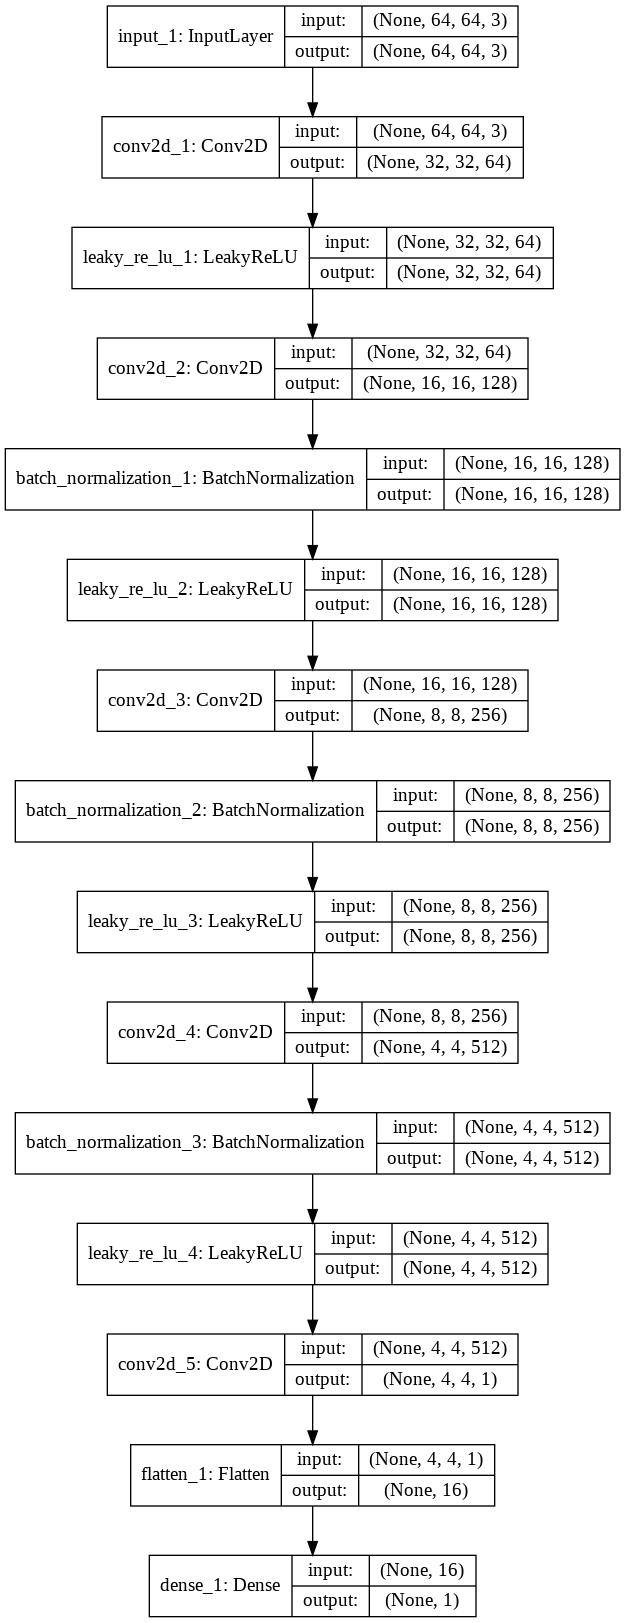

In [0]:
  plot_model(Discriminator,show_shapes = True)

### Implementing the generator of DCGAN
Now, we will implement the generator of the DCGAN, which consists of a sequence of transpose
convolutional layers that progressively upsample the input noise sample to generate a fake image.
The generator has the following architecture:
<br>
![DCGAN Generator](DCGAN_gen.png)

**Some important points:**
- Pass in use_bias=False,padding='same' in your convolutional layers.
- All intermediate convolutional layers will have relu activation except the last one, which will have tanh.
- All other properties can be inferred from the above diagram

Implement the generator in the cell below

In [0]:
def build_generator():
   
    In_1= Input(shape= (NOISE_DIM,)  )

    l1 =   Dense(4*4*1024,use_bias=False)(In_1)
    l1=   BatchNormalization()(l1)
    l1 =   LeakyReLU(alpha=0.3)(l1)
    l1 =    Reshape((4,4,1024))(l1)
    l1 =   Conv2DTranspose(512, kernel_size=(5,5),padding='same',strides =(2,2) ,use_bias=False)(l1)
    l1 =   BatchNormalization()(l1)
    l1 =   LeakyReLU(alpha=0.3)(l1)
    l1 =   Conv2DTranspose(256, kernel_size=(5,5),padding='same',strides =(2,2) ,use_bias=False)(l1)
    l1 =   BatchNormalization()(l1)
    l1 =     LeakyReLU(alpha=0.3)(l1)
    l1 =   Conv2DTranspose(128, kernel_size=(5,5),padding='same',strides =(2,2) ,use_bias=False)(l1)
    l1 =   BatchNormalization()(l1)
    l1 =   LeakyReLU(alpha=0.3)(l1)
    l1 =   Conv2DTranspose(CHANNELS, kernel_size=(5,5),padding='same',strides =(2,2),activation='tanh' ,use_bias=False)(l1)
    mod = Model(inputs=In_1, outputs=l1)
  
    return mod


In [0]:
Generator = build_generator()

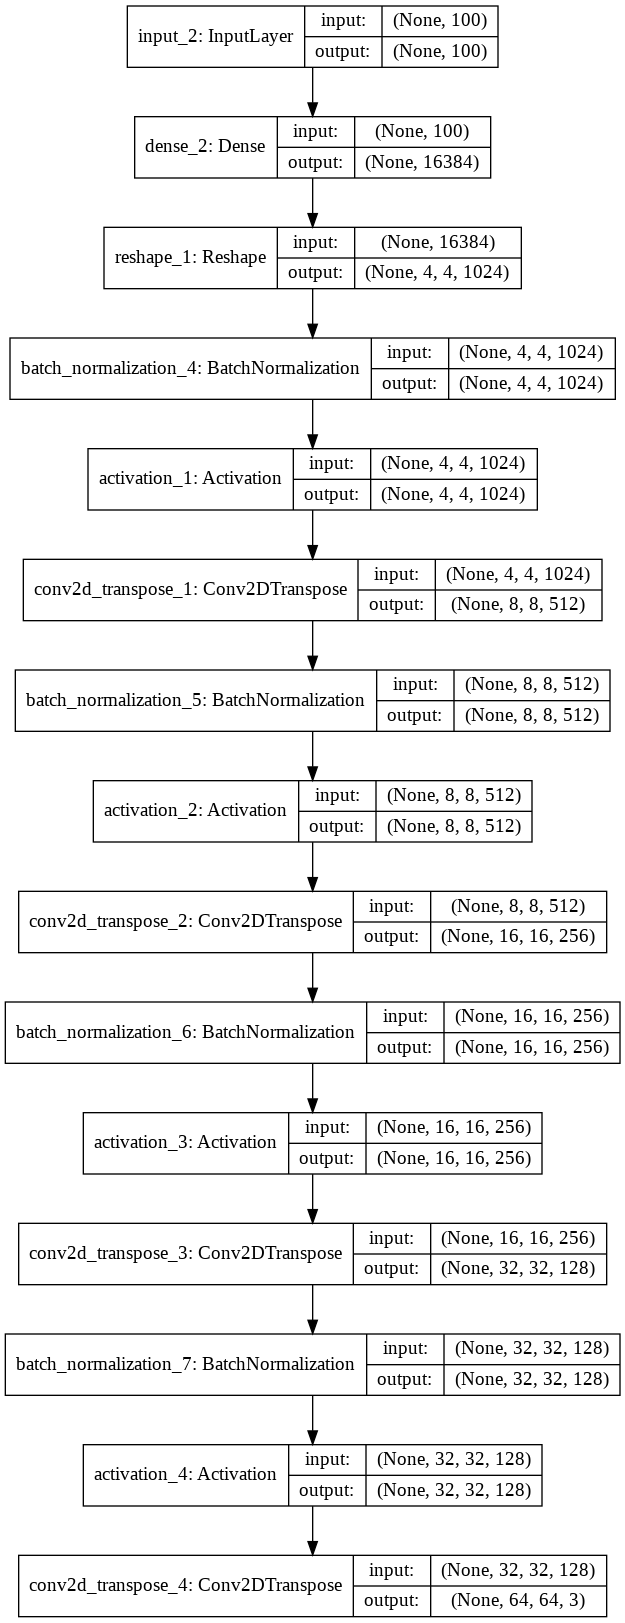

In [0]:
plot_model(Generator,show_shapes = True)

### DCGAN Training Loop
Next, you will implement the training loop for the DCGAN. A DCGAN is simply a GAN with a
specific type of generator and discriminator; thus, we train it in exactly the same way as a standard
GAN. The pseudo-code for the training procedure is shown below.

**Algorithm:**    
1. Draw m training examples {x<sup>(1)</sup>,...,x<sup>(m)</sup>} from the data distribution p<sub>data</sub>.
2. Draw m noise samples {z<sup>(1)</sup>,...,z<sup>(m)</sup>} from the noise distribution p<sub>z</sub>.    
3. Generate fake images from the noise: G(z<sup>(i)</sup>) for i in {1,....,m}.    
4. Compute discriminator's loss on real images and fake images batches and then update the parameters.
5. Draw m NEW noise samples {z<sup>(1)</sup>,...,z<sup>(m)</sup>} from the noise distribution p<sub>z</sub>.    
6. Generate fake images from the noise: G(z<sup>(i)</sup>) for i in {1,....,m}.    
7. Freeze the discriminator.
8. Compute generator's loss then update the parameters.
9. Unfreeze the discriminator.

Before we move to writing the training loop, we will need to create a "combined" model that will attach the discriminator over the generator. This model will be used to train the generator as the discriminator will act as an adversary for the generator and force it to generate realistic images.

In this function below you need to create a model that:
- Takes noise z as input (Matching the noise dimensions defined at the top of the notebook)
- Gets a fake image generated from the generator using this noise z
- "Freezes" the discriminator (Setting all layers of the discriminator as untrainable)
- Outputs the output of the discriminator based on the input z.

Remember to compile the model before returning it.

In [0]:
def build_gan(gen,disc):    
    inp = Input(shape=(NOISE_DIM,))
    image = gen(inp)
    fin = disc(image)
    model = Model(inp,fin)

    
    return model

In [0]:
GAN = build_gan(Generator,Discriminator)

Write your training loop in the cell bellow. Some important points to keep in mind:
- You need to compile the discriminator after creating an instance using build_discriminator()
- Use the provided load_data() function to well... load the data. You can choose between generating Windows or Apple emojis
- The entire data will be loaded as it is small enough to fit into memory (Finally no data generators, right?) BUT you still need to loop over the data in batches. Starter code is provided to you.
- To train your models, we won't make use of <code>fit</code> instead we will use <code>train_on_batch</code> to train our model over batches. This method will return your model's loss over a particular batch, which you will use to output and store your history of losses.
- Additionally, we will be generating samples after some epochs and storing the result on disk. The code is provided to do this.

In [0]:
adam = Adam(lr=0.0001, beta_1=0.5, decay=8e-8)

In [0]:
X_train = load_data()

In [0]:
def gan_training_loop(intervals=200):
    # Setup Models here

    
    total_size = X_train.shape[0]
    
    indices = np.arange(0,total_size ,BATCH_SIZE)
    all_disc_loss = []
    all_gen_loss = []
    if total_size % BATCH_SIZE:
        indices = indices[:-1]
    for e in range(50):
        progress_bar = Progbar(target=len(indices))
        np.random.shuffle(indices)
        epoch_gen_loss = []
        epoch_disc_loss = []
        for i,index in enumerate(indices):
            # Write your code here
            noise = sample_noise()
            image_batch = X_train[index:index+BATCH_SIZE]

            generated_imgs = Generator.predict(noise)
            X = np.concatenate((image_batch, generated_imgs))
            labels = [1] * BATCH_SIZE + [0] * BATCH_SIZE
            loss_on_disc = Discriminator.train_on_batch(X, labels)

            # Before training your generator using the combined model, freeze all layers of the discriminator first.
            # Unfreeze after your call to train_on_batch
            noise = sample_noise()
            Discriminator.trainable = False
            loss_on_generator = GAN.train_on_batch(noise, [1] * BATCH_SIZE)
            Discriminator.trainable = True
          

            if not (e % intervals):
              save_samples(generated_imgs,e)     
            
            disc_loss = loss_on_disc
            epoch_disc_loss.append(disc_loss)
            
       
            gen_loss = loss_on_generator
            epoch_gen_loss.append(gen_loss)
            progress_bar.update(i+1)
        if not (e%intervals):
          pass
          # Save weights here
          #Discriminator.save_weights(os.path.join(BASE_DIR,'discriminator'),True)
          #Generator.save_weights(os.path.join(BASE_DIR,'generator'),True)
            
        avg_epoch_disc_loss = np.array(epoch_disc_loss).mean()
        avg_epoch_gen_loss = np.array(epoch_gen_loss).mean()
        all_disc_loss.append(avg_epoch_disc_loss)
        all_gen_loss.append(avg_epoch_gen_loss)

        print("Epoch: %d | Discriminator Loss: %f | Generator Loss: %f" % (e+1,avg_epoch_disc_loss,avg_epoch_gen_loss))
    return all_disc_loss,all_gen_loss

In [0]:
Discriminator.compile(loss='binary_crossentropy',
                                  optimizer=adam,
                                  metrics=['accuracy'])
Generator.compile(loss='binary_crossentropy',
                                  optimizer=adam,
                                  metrics=['accuracy'])
GAN.compile(loss='binary_crossentropy',
                                  optimizer=adam,
                                  )


### Training the GAN
We will train a DCGAN to generate fake Apple emojis. 1 epoch should take about 15 seconds on Google Colab.

Train your DCGAN in the below cell

In [0]:
all_disc_loss,all_gen_loss = gan_training_loop()


### Generating Samples and Analysis

- Plot your discriminator and generator losses and explain how it represents the MiniMax game in play, and comment on the trends you observe.
- Generate random 5 noise samples and their corresponding fake images.
- Mention if you observe any failure modes
- **BONUS (5%):** Try generating some good samples, and try interpolating the input noise samples (Vector Arithmetic) to see if the results are as expected.

In [0]:
def plot_loss(gen_loss,disc_loss):
    plt.plot(gen_loss)
    plt.plot(disc_loss)
    plt.title('GAN Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Generator', 'Discriminator'], loc='upper left')
    plt.show()
    

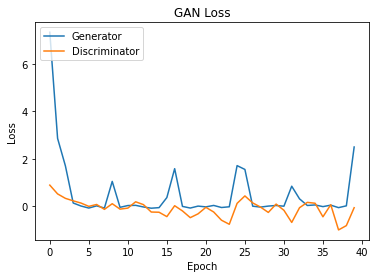

In [0]:
plot_loss(all_gen_loss,all_disc_loss)

Since colab was getting disconnected every 30 minutes or so, I could not train everything in one loop which explains why the epochs are low.

 Generally, the loss for the GAN is such that the losses for both (Generator and Discrminator) begin withh different values but tend to converge to a particular point. We can also see the minimax game at play here. Whenever one of the model improves (i.e) lowers it's loss, the loss for the other model goes up. For example, if the generator reduces its loss, it has learnt to make images to fool the Discrminator better. So now, the discrminator will perform poorly till it learns to discrminate between the original images and fake images produced by the improved generator.

# Random samples and the images they generate

In [0]:
def sample_noise_five():
  mu, sigma = 0, 1
  return np.reshape(np.random.normal(mu,sigma,NOISE_DIM * 5),(5,NOISE_DIM))

In [0]:
def view_results(noise_vect,images,n=5):
    fig = figure(figsize=(15,15))
    for i in range(n):  
      #print(noise_vect[i])
      plt.figure(figsize=(3,3))
      plt.imshow(images[i,:,:,:])
      axis('off')  
      #a=fig.add_subplot(1,n,i+1)
      #image = mpimg.imread(images[i])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 1080x1080 with 0 Axes>

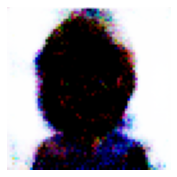

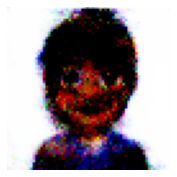

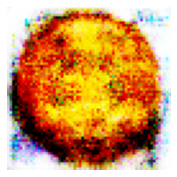

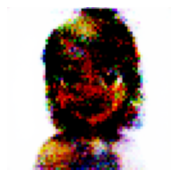

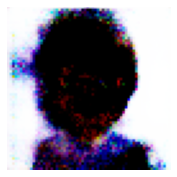

In [0]:


noise_v = sample_noise_five()

images = Generator.predict(noise_v)
view_results(noise_v,images)


# Since the results for this part are pretty bad, I did the vector arithmetic in part two where the results were slightly better.

## PART 2: Stablizing GANs

In the first part, we trained our GAN using the standard methods proposed initially. In this part we will tweak our models and our training loop based on suggestions that deep learning researchers have come up with through their experiences. We will see if we encountered into typical problems faced while training GANs and see if these proposed methods improve our GANs and resolve issuse previously faced.

We have already implemented a GAN based on the recommendations made by Alec Radford, et al. in the 2015 paper titled [“Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks.”](https://arxiv.org/abs/1511.06434)



We have:
1. Downsampled using strided convolutions
2. Upsampled using strided convolutions
3. Used LeakyReLu in our discriminator, and ReLu in the generator and Tanh for the output of the generator.
4. Used BatchNormalization in both the discriminator and generator.

In addition to these, we will also make use of some more tips from the aforementioned paper, as well as tips from Soumith Chintala, who is one of the co-authors of the DCGAN paper in his [NIPS presentation](https://www.youtube.com/watch?v=X1mUN6dD8uE)

### Modifications in the Models

Here are some suggested modifications in the generator and discriminator models:

- Use LeakyReLu in BOTH the generator and discriminator
- Use Gaussian Weight initialization with mean=0 and std = 0.02. (Use the imported RandomNormal function to get weights and pass it in as the kernel_initializer argument in a convolutional layer)
- Use Adam optimizer

Make these modifications in your generator and discriminator models.

In [0]:
RN = RandomNormal(mean=0.0, stddev=0.02)

In [0]:

def build_discriminator():
    noise = sample_noise()
    In_1 = Input(shape= (64,64,3))  
    l1 = Conv2D(64, kernel_size=(4,4),kernel_initializer=RN,padding='same',strides =(2,2) ,use_bias=False)(In_1)
    l1= LeakyReLU(alpha=0.3)(l1)
    l1 = Conv2D(128, kernel_size=(4,4),kernel_initializer=RN,padding='same',strides =(2,2) ,use_bias=False)(l1)
    l1= BatchNormalization()(l1)
    l1=LeakyReLU(alpha=0.3)(l1)
    l1 = Conv2D(256, kernel_size=(4,4),kernel_initializer=RN,padding='same',strides =(2,2) ,use_bias=False)(l1)
    l1= BatchNormalization()(l1)
    l1=LeakyReLU(alpha=0.3)(l1)

    l1=Conv2D(512, kernel_size=(4,4),kernel_initializer=RN,padding='same',strides =(2,2) ,use_bias=False)(l1)
    l1=BatchNormalization()(l1)
    l1=LeakyReLU(alpha=0.3)(l1)
    l1 = Conv2D(1, kernel_size=(4,4),kernel_initializer=RN,padding='same',strides =(1,1) ,use_bias=False)(l1)
    l1=Flatten()(l1)
    l1=Dense(1, use_bias=False,activation='sigmoid')(l1)
    
    Discriminator = Model(inputs=In_1, outputs=l1)
    return Discriminator
    

In [0]:
def build_generator():
   
    In_1= Input(shape= (NOISE_DIM,)  )

    l1 =   Dense(4*4*1024,use_bias=False)(In_1)
    l1=   BatchNormalization()(l1)
    l1 =   LeakyReLU(alpha=0.3)(l1)
    l1 =    Reshape((4,4,1024))(l1)
    l1 =   Conv2DTranspose(512, kernel_size=(5,5),kernel_initializer=RN,padding='same',strides =(2,2) ,use_bias=False)(l1)
    l1 =   BatchNormalization()(l1)
    l1 =   LeakyReLU(alpha=0.3)(l1)
    l1 =   Conv2DTranspose(256, kernel_size=(5,5),kernel_initializer=RN,padding='same',strides =(2,2) ,use_bias=False)(l1)
    l1 =   BatchNormalization()(l1)
    l1 =     LeakyReLU(alpha=0.3)(l1)
    l1 =   Conv2DTranspose(128, kernel_size=(5,5),kernel_initializer=RN,padding='same',strides =(2,2) ,use_bias=False)(l1)
    l1 =   BatchNormalization()(l1)
    l1 =   LeakyReLU(alpha=0.3)(l1)
    l1 =   Conv2DTranspose(CHANNELS, kernel_size=(5,5),padding='same',strides =(2,2),activation='tanh' ,use_bias=False)(l1)
    mod = Model(inputs=In_1, outputs=l1)
  
    return mod


In [0]:
def build_gan(gen,disc):

  inp = Input(shape=(NOISE_DIM,))
  image = gen(inp)
  fin = disc(image)
  model = Model(inp,fin)
    
  return model

### Scale Images to the Range [-1,1]
We already know that normalizing images improves training for any model. We will scale our images in the range [-1,1] since we are using a tanh activation in our generator. This will make the fake generated images and real images in the same range and will enable our discriminator to learn better.    
Implement the following function to normalize a numpy array containing images. **Note:** The images will be in the range [0,255]

In [0]:
def normalize(images):
    images=images.astype('float32')
    images=(images-127.5)/127.5
    return images

### Use Gaussian Latent Space
Previously we have been using a uniform distribution to sample a latent space as recommended in the DCGAN paper, but more recently researchers suggest to use a Standard Gaussian distribution to sample the latent space. Modify the <code>sample_noise</code> function to sample fomr a Gaussian distribution.

In [0]:
def sample_noise():
  mu, sigma = 0, 1
  return np.reshape(np.random.normal(mu,sigma,NOISE_DIM * BATCH_SIZE),(BATCH_SIZE,NOISE_DIM))


### Use Label Smoothing
Normally, we use hard labels 1s and 0s to train our GANs. Researchers have suggested to smooth labels and use "soft" labels . This is said to have a "regularizing" effect on the training.

#### Real Label Smoothing
For Real labels, i.e. 1s, we will smooth the labels uniformly between [0.7,1.2]. Use np.random.random for this.

In [0]:
def smooth_real_labels(y):
    smoothed = np.random.uniform(low=0.8, high=1.2, size=y.shape)
    return smoothed

#### Fake Label Smoothing

In [0]:
def smooth_fake_labels(y):
    smoothed = np.random.uniform(low=0.0, high=0.3, size=y.shape)
    return smoothed

In [0]:
def swap(swap_this,from_this):
    arr = np.random.binomial(1,0.2,size=swap_this.shape[0])
    swap_this[arr == 1] = from_this[arr==1]
    return swap_this


We will make use of these functions later in our training loop.

### Train Discriminator with Real and Fake Images separately
Previously we were combining our fake and real images batches and doing one update to our discriminator. Researchers suggest that the best practice is to train our discriminator in two updates, one for the real images and one for the fake images.

### Flip some labels randomly while training the Generator
Soumith Chintala also suggests that in practice, ocassionally flipping the labels of the generator may help (Swapping Real and Fake)

### Modified Training Loop

Incorporate the above mentioned suggestions in your training process. You don't have to apply all of them. See which combination works best for you. Mention the methods you made use of.

In [0]:
def save_samples(generated_images,step,save_at="samples/"):

  if not os.path.exists('Generate_Images'):
        os.mkdir('./Generate_Images')


  sample_image = create_image_grid(generated_images)
  img = k_image.array_to_img(sample_image)
  img.save(os.path.join('./Generate_Images', 'generated_image_' + str(step) + '.png'))

In [0]:
def plot_loss(gen_loss,disc_loss):
    plt.plot(gen_loss)
    plt.plot(disc_loss)
    plt.title('GAN Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Generator', 'Discriminator'], loc='upper left')
    plt.show()

In [0]:
def sample_noise_five():
  mu, sigma = 0, 1
  return np.reshape(np.random.normal(mu,sigma,NOISE_DIM * 5),(5,NOISE_DIM))

In [0]:
def view_results(noise_vect,images,n=5):
    fig = figure(figsize=(15,15))
    for i in range(n):  
      #print(noise_vect[i])
      plt.figure(figsize=(3,3))
      plt.imshow(images[i,:,:,:])
      axis('off')  
      #a=fig.add_subplot(1,n,i+1)
      #image = mpimg.imread(images[i])


In [0]:
X_train = load_data()
X_train = normalize(X_train)

In [0]:
  def gan_training_loop(intervals=200):
    # Setup Models here

    total_size = X_train.shape[0]

    indices = np.arange(0,total_size ,BATCH_SIZE)
    all_disc_loss = []
    all_gen_loss = []
    all_disc_acc=[]
    if total_size % BATCH_SIZE:
        indices = indices[:-1]
    for e in range(40):
        progress_bar = Progbar(target=len(indices))
        np.random.shuffle(indices)
        epoch_gen_loss = []
        epoch_disc_loss = []
        epoch_disc_acc=[]
        for i,index in enumerate(indices):
            # Write your code here

            noise = sample_noise()
            image_batch = X_train[index:index+BATCH_SIZE]
            generated_imgs = Generator.predict(noise)
            labels_true = np.array([1] * BATCH_SIZE)
            labels_true = smooth_real_labels(labels_true)
            labels_fake =  np.array([0] * BATCH_SIZE)
            labels_fake = smooth_fake_labels(labels_fake)

            #labels_true = swap(labels_true,labels_fake)
            #labels_fake = swap(labels_fake,labels_true)
            Discriminator.trainable = True        
            loss_on_disc_real = Discriminator.train_on_batch(image_batch, labels_true)
            loss_on_disc_fake = Discriminator.train_on_batch(generated_imgs, labels_fake)           
            loss_on_disc_real = Discriminator.train_on_batch(image_batch, labels_true)
            loss_on_disc_fake = Discriminator.train_on_batch(generated_imgs, labels_fake)
        
                    
            tot_disc_loss = 0.5*np.add(loss_on_disc_real,loss_on_disc_fake)



            # Before training your generator using the combined model, freeze all layers of the discriminator first.
            # Unfreeze after your call to train_on_batch


            noise = sample_noise()
            Discriminator.trainable = False
           
            gen_loss = GAN.train_on_batch(noise, labels_true)
            
            
            
            #Discriminator.trainable = True
            
            if not (e % intervals):
               save_samples(generated_imgs,e)     
            
            disc_loss = tot_disc_loss
            epoch_disc_loss.append(disc_loss[0])
            epoch_disc_acc.append(disc_loss[1])
       
            epoch_gen_loss.append(gen_loss)
            progress_bar.update(i+1)
        if not (e%intervals):
          pass          
          # Save weights here
          #Discriminator.save_weights(os.path.join(BASE_DIR,'discriminator_F'),True)
          #Generator.save_weights(os.path.join(BASE_DIR,'generator_F'),True)
          #GAN.save_weights(os.path.join(BASE_DIR,'GAN_save_F'),True)
        
        avg_epoch_disc_loss = np.array(epoch_disc_loss).mean()
        avg_epoch_gen_loss = np.array(epoch_gen_loss).mean()
        all_disc_loss.append(avg_epoch_disc_loss)
        avg_epoch_disc_acc = np.array(epoch_disc_acc).mean()
        all_gen_loss.append(avg_epoch_gen_loss)
        

        print("Epoch: %d | Discriminator Loss: %f |  Accuracy :  %f | Generator Loss: %f" % (e+1,avg_epoch_disc_loss,avg_epoch_disc_acc,avg_epoch_gen_loss))
        
    return all_disc_loss,all_gen_loss

In [0]:
def gan_training_loop_disc(intervals=200):
     # Setup Models here

    total_size = X_train.shape[0]

    indices = np.arange(0,total_size ,BATCH_SIZE)
    all_disc_loss = []
    all_gen_loss = []
    #all_disc_acc=[]
    if total_size % BATCH_SIZE:
        indices = indices[:-1]
    for e in range(30):
        progress_bar = Progbar(target=len(indices))
        np.random.shuffle(indices)
        epoch_gen_loss = []
        epoch_disc_loss = []
        #epoch_disc_acc=[]
        for i,index in enumerate(indices):
            # Write your code here

            noise = sample_noise()
            image_batch = X_train[index:index+BATCH_SIZE]
            #global sess
            #global graph
            #with graph.as_default():
             #   set_session(sess)
            generated_imgs = Generator.predict(noise)
           
            labels_true = np.array([1] * BATCH_SIZE)
            labels_true = smooth_real_labels(labels_true)
            labels_fake =  np.array([0] * BATCH_SIZE)
            labels_fake = smooth_fake_labels(labels_fake)

            #labels_true = swap(labels_true,labels_fake)
            #labels_fake = swap(labels_fake,labels_true)

            
            loss_on_disc_real = Discriminator.train_on_batch(image_batch, labels_true)
            loss_on_disc_fake = Discriminator.train_on_batch(generated_imgs, labels_fake)
            loss_on_disc_real = Discriminator.train_on_batch(image_batch, labels_true)
            loss_on_disc_fake = Discriminator.train_on_batch(generated_imgs, labels_fake)          
            tot_disc_loss = 0.5*np.add(loss_on_disc_real,loss_on_disc_fake)

          
            if not (e % intervals):
              save_samples(generated_imgs,e)     
            
            
            disc_loss = tot_disc_loss
            epoch_disc_loss.append(disc_loss[0])
            #epoch_disc_acc.append(disc_loss[1])
            
            epoch_gen_loss.append(1)
            progress_bar.update(i+1)
        
        if not (e%intervals):
                 
          pass
          # Save weights here
          #Discriminator.save_weights(os.path.join(BASE_DIR,'discriminator_save'),True)
          #Generator.save_weights(os.path.join(BASE_DIR,'generator_save'),True)
          #GAN.save_weights(os.path.join(BASE_DIR,'GAN_save'),True)
        
        avg_epoch_disc_loss = np.array(epoch_disc_loss).mean()
        avg_epoch_gen_loss = np.array(epoch_gen_loss).mean()
        all_disc_loss.append(avg_epoch_disc_loss)
        #avg_epoch_disc_acc = np.array(epoch_disc_acc).mean()
        all_gen_loss.append(avg_epoch_gen_loss)
        

        print("Epoch: %d | Discriminator Loss:  %f | Generator Loss: %f" % (e+1,avg_epoch_disc_loss,avg_epoch_gen_loss))
    return all_disc_loss,all_gen_loss
  

In [0]:
  def gan_training_loop_gen(intervals=200):
    # Setup Models here

    total_size = X_train.shape[0]

    indices = np.arange(0,total_size ,BATCH_SIZE)
    all_disc_loss = []
    all_gen_loss = []
   
    if total_size % BATCH_SIZE:
        indices = indices[:-1]
    for e in range(60):
        progress_bar = Progbar(target=len(indices))
        np.random.shuffle(indices)
        epoch_gen_loss = []
        epoch_disc_loss = []
        
        for i,index in enumerate(indices):
            # Write your code here

            #global sess
            #global graph
            #with graph.as_default():
             #   set_session(sess)
            noise = sample_noise()
            #image_batch = X_train[index:index+BATCH_SIZE]
            #generated_imgs = Generator.predict(noise)
            labels_true = np.array([1] * BATCH_SIZE)
            labels_true = smooth_real_labels(labels_true)
            labels_fake =  np.array([0] * BATCH_SIZE)
            labels_fake = smooth_fake_labels(labels_fake)

            #labels_true = swap(labels_true,labels_fake)
            #labels_fake = swap(labels_fake,labels_true)
            gen_loss = GAN.train_on_batch(noise, labels_true)
            
      
            
            #if not (e % intervals):
            #    save_samples(generated_imgs,e)     
            
            disc_loss = 1
            epoch_disc_loss.append(disc_loss)
            
            epoch_gen_loss.append(gen_loss)
            progress_bar.update(i+1)
        if not (e%intervals):
          pass          
          # Save weights here
          #Discriminator.save_weights(os.path.join(BASE_DIR,'discriminator_save'),True)
          #Generator.save_weights(os.path.join(BASE_DIR,'Generator_save'),True)
          #GAN.save_weights(os.path.join(BASE_DIR,'GAN_save'),True)
        
            
        avg_epoch_disc_loss = np.array(epoch_disc_loss).mean()
        avg_epoch_gen_loss = np.array(epoch_gen_loss).mean()
        all_disc_loss.append(avg_epoch_disc_loss)
        all_gen_loss.append(avg_epoch_gen_loss)
        

        print("Epoch: %d | Discriminator Loss: %f | Generator Loss: %f" % (e+1,avg_epoch_disc_loss,avg_epoch_gen_loss))
        
    return all_disc_loss,all_gen_loss

In [19]:

Discriminator = build_discriminator()
Generator = build_generator()

GAN = build_gan(Generator,Discriminator)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
adam = Adam(lr=0.0002, beta_1=0.5)


In [0]:
Discriminator.load_weights('/content/drive/My Drive/discriminator')
Generator.load_weights('/content/drive/My Drive/generator')
GAN.load_weights('/content/drive/My Drive/dcgan')

In [0]:
  Discriminator.compile(loss='binary_crossentropy',
                                    optimizer=adam,
                                    metrics=['accuracy'])
  Generator.compile(loss='binary_crossentropy',
                                    optimizer=adam,
                                    metrics=['accuracy'])
  GAN.compile(loss='binary_crossentropy',
                                    optimizer=adam,
                                    )    
  

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
all_disc_loss,all_gen_loss = gan_training_loop()

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1/5 [=====>........................] - ETA: 1:18

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5/5 [==============================] - 22s 4s/step
Epoch: 1 | Discriminator Loss: 0.390956 |  Accuracy :  0.000000 | Generator Loss: 2.407276
5/5 [==============================] - 3s 527ms/step
Epoch: 2 | Discriminator Loss: 0.383841 |  Accuracy :  0.000000 | Generator Loss: 2.499709
5/5 [==============================] - 3s 531ms/step
Epoch: 3 | Discriminator Loss: 0.269350 |  Accuracy :  0.000000 | Generator Loss: 1.017298
5/5 [==============================] - 3s 533ms/step
Epoch: 4 | Discriminator Loss: 0.470234 |  Accuracy :  0.000000 | Generator Loss: 0.594109
5/5 [==============================] - 3s 535ms/step
Epoch: 5 | Discriminator Loss: 0.324567 |  Accuracy :  0.000000 | Generator Loss: 0.019903
5/5 [==============================] - 3s 536ms/step
Epoch: 6 | Discriminator Loss: 0.216632 |  Accuracy :  0.000000 | Generator Loss: -0.001037
5/5 [==============================] - 3s 535ms/step
Epoch: 7 | Discriminator Loss: 0.219659 |  Accuracy :  0.000000 | Generator Loss: -0

In [0]:
for i in range(5):
  print(i)
  
  # Train Gen
  
  Discriminator.trainable = False
  
  Discriminator.compile(loss='binary_crossentropy',
                                    optimizer=adam,
                                    metrics=['accuracy'])
  GAN.compile(loss='binary_crossentropy',
                                    optimizer=adam,
                                    )    
  
  
 
  all_disc_loss,all_gen_loss = gan_training_loop_gen()

  
  # Train Disc
  Discriminator.trainable = True
  
  
  
  Discriminator.compile(loss='binary_crossentropy',
                                    optimizer=adam,
                                    metrics=['accuracy'])

  
 
  all_disc_loss,all_gen_loss = gan_training_loop_disc()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 1080x1080 with 0 Axes>

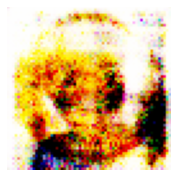

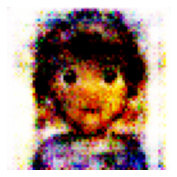

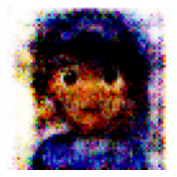

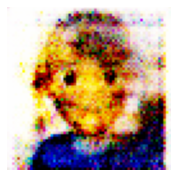

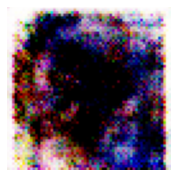

In [0]:
noise_v = sample_noise_five()

images = Generator.predict(noise_v)

view_results(noise_v,images)



### Analysis 
Repeat the above analysis and mention changes you observed in terms of training and quality of fake images

The biggest observable change is that the fake images produced actually look like emojis unlike the images in part one which are just noise. Secondly, training was quicker. I was able to achieve these results in about 200-300 epochs. However, I also trained my model a little differently where I made different training loops for the generator and discriminator. I then adjusted the number of times training was done on both corresponding to how quickly their loss went down.

Another point about the fake images is that they seem to be pretty similar. There were a couple of reasons for this. One was that the dataset was small. However, the more important reason for this was something called 'Model collapse' where your generator learns one particular way to fool the discriminator and keeps doing that over and over again.

Another point I observed was that losses do not have a direct correspondence with the quality of the images. If I train the current model more, the loss for both the models was pretty low i.e in the 0.001-0.19 range. However, the image quality went from recognizable faces to noise. 



# Loss Plot

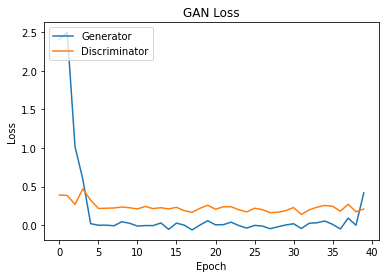

In [0]:
plot_loss(all_gen_loss,all_disc_loss)    


Since colab was getting disconnected every 30 minutes or so, I could not train everything in one loop which explains why the epochs are low.

 The loss for the GAN is such that the losses for both (Generator and Discrminator) begin withh different values but tend to converge to a particular point. We can also see the minimax game at play here. Whenever one of the model improves (i.e) lowers it's loss, the loss for the other model goes up. For example, if the generator reduces its loss, it has learnt to make images to fool the Discrminator better. So now, the discrminator will perform poorly till it learns to discrminate between the original images and fake images produced by the improved generator. The above plot is from the later parts of my training so we can see that they have both become relatively stable and in a way, they are playing a zero sum game because as soon as one of them improves, the other model learns and undoes the reduction in the loss for the model that had improved initially.

# BONUS - Vector Arithmetic

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 1080x1080 with 0 Axes>

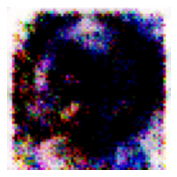

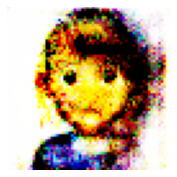

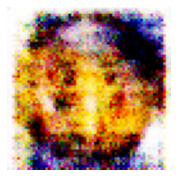

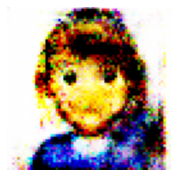

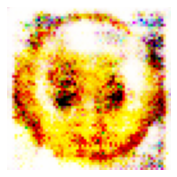

In [0]:
# Taking five samples and plotting them

first = sample_noise_five()
res = Generator.predict(first)
view_results(first,res)


In [0]:
first.shape

(5, 100)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 1080x1080 with 0 Axes>

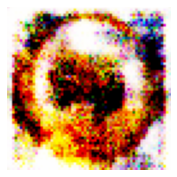

In [0]:
# Taking the first image and adding the fourth to it


f = first[4].reshape(100,1) + first[0].reshape(100,1)

f = f.reshape(1,100)
res = Generator.predict(f)
view_results(f,res,1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 1080x1080 with 0 Axes>

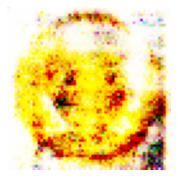

In [0]:
# Taking the first image and adding the fourth to it


f = first[4].reshape(100,1) - first[0].reshape(100,1)

f = f.reshape(1,100)
res = Generator.predict(f)
view_results(f,res,1)


In [0]:
"""
This is an intersting result. This tells us that the fifth image in the samples taken for the vector arithmetic part is almost
the same as the first image subtracted from the fourth image
"""

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 1080x1080 with 0 Axes>

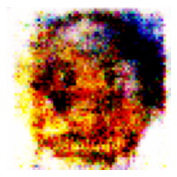

In [0]:
# Taking the first image and adding the fourth to it


f = first[4].reshape(100,1) + first[0].reshape(100,1) + first[1].reshape(100,1)

f = f.reshape(1,100)
res = Generator.predict(f)
view_results(f,res,1)


## BONUS - 10%
The current training set was a subset of the actual emojis dataset. In the filtering process, most inanimate objects were removed and the focus was on front-facing emojis. Train the model over the full dataset or a subset of your choice and repeat the above analysis

In [0]:
# Training on the Apple train dataset with the flags part only

In [0]:
direct = '/content/drive/My Drive/Train/*'

In [0]:
# Loading the train set

def load_data():
    base_dir = direct
    train_files = glob(base_dir)
    train_files.sort()
    train_files = train_files[30:60]
    train_images = np.array([cv2.resize(remove_transparency(cv2.imread(f,-1),255),tuple(IMAGE_SHAPE)) for f in train_files])
    return train_images

In [0]:
X_train = load_data()
X_train = normalize(X_train)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


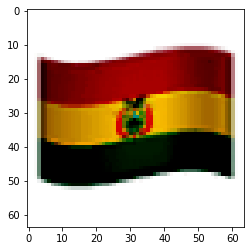

In [24]:
plt.imshow(X_train[-1])

In [0]:
def sample_noise():
    return np.reshape(np.random.randn(NOISE_DIM * len(X_train)),(len(X_train),NOISE_DIM))

In [0]:
def gan_training_loop_disc(intervals=200):
     # Setup Models here

    total_size = X_train.shape[0]

    indices = np.arange(0,total_size ,len(X_train))
    all_disc_loss = []
    all_gen_loss = []
    #all_disc_acc=[]
    if total_size % len(X_train):
        indices = indices[:-1]
    for e in range(29):
        progress_bar = Progbar(target=len(indices))
        np.random.shuffle(indices)
        epoch_gen_loss = []
        epoch_disc_loss = []
        #epoch_disc_acc=[]
        for i,index in enumerate(indices):
            # Write your code here

            noise = sample_noise()
            image_batch = X_train
            #global sess
            #global graph
            #with graph.as_default():
             #   set_session(sess)
            generated_imgs = Generator.predict(noise)
           
            labels_true = np.array([1] * len(X_train))
            labels_true = smooth_real_labels(labels_true)
            labels_fake =  np.array([0] * len(X_train))
            labels_fake = smooth_fake_labels(labels_fake)

            #labels_true = swap(labels_true,labels_fake)
            #labels_fake = swap(labels_fake,labels_true)

            
            loss_on_disc_real = Discriminator.train_on_batch(image_batch, labels_true)
            loss_on_disc_fake = Discriminator.train_on_batch(generated_imgs, labels_fake)
            loss_on_disc_real = Discriminator.train_on_batch(image_batch, labels_true)
            loss_on_disc_fake = Discriminator.train_on_batch(generated_imgs, labels_fake)          
            tot_disc_loss = 0.5*np.add(loss_on_disc_real,loss_on_disc_fake)

          
            if not (e % intervals):
              save_samples(generated_imgs,e)     
            
            
            disc_loss = tot_disc_loss
            epoch_disc_loss.append(disc_loss[0])
            #epoch_disc_acc.append(disc_loss[1])
            
            epoch_gen_loss.append(1)
            progress_bar.update(i+1)
        
        if not (e%intervals):
                 
          pass
          # Save weights here
          #Discriminator.save_weights(os.path.join(BASE_DIR,'discriminator_save'),True)
          #Generator.save_weights(os.path.join(BASE_DIR,'generator_save'),True)
          #GAN.save_weights(os.path.join(BASE_DIR,'GAN_save'),True)
        
        avg_epoch_disc_loss = np.array(epoch_disc_loss).mean()
        avg_epoch_gen_loss = np.array(epoch_gen_loss).mean()
        all_disc_loss.append(avg_epoch_disc_loss)
        #avg_epoch_disc_acc = np.array(epoch_disc_acc).mean()
        all_gen_loss.append(avg_epoch_gen_loss)
        

        print("Epoch: %d | Discriminator Loss:  %f | Generator Loss: %f" % (e+1,avg_epoch_disc_loss,avg_epoch_gen_loss))
    return all_disc_loss,all_gen_loss
  

In [0]:
  def gan_training_loop(intervals=200):
    # Setup Models here

    total_size = X_train.shape[0]

    indices = np.arange(0,total_size ,len(X_train))
    all_disc_loss = []
    all_gen_loss = []
    all_disc_acc=[]
    if total_size % len(X_train):
        indices = indices[:-1]
    for e in range(50):
        progress_bar = Progbar(target=len(indices))
        np.random.shuffle(indices)
        epoch_gen_loss = []
        epoch_disc_loss = []
        epoch_disc_acc=[]
        for i,index in enumerate(indices):
            # Write your code here

            noise = sample_noise()
            image_batch = X_train
            generated_imgs = Generator.predict(noise)
            labels_true = np.array([1] * len(X_train))
            labels_true = smooth_real_labels(labels_true)
            labels_fake =  np.array([0] * len(X_train))
            labels_fake = smooth_fake_labels(labels_fake)

            #labels_true = swap(labels_true,labels_fake)
            #labels_fake = swap(labels_fake,labels_true)
            Discriminator.trainable = True        
            loss_on_disc_real = Discriminator.train_on_batch(image_batch, labels_true)
            loss_on_disc_fake = Discriminator.train_on_batch(generated_imgs, labels_fake)           
            loss_on_disc_real = Discriminator.train_on_batch(image_batch, labels_true)
            loss_on_disc_fake = Discriminator.train_on_batch(generated_imgs, labels_fake)
        
                    
            tot_disc_loss = 0.5*np.add(loss_on_disc_real,loss_on_disc_fake)



            # Before training your generator using the combined model, freeze all layers of the discriminator first.
            # Unfreeze after your call to train_on_batch


            noise = sample_noise()
            Discriminator.trainable = False
           
            gen_loss = GAN.train_on_batch(noise, labels_true)
            gen_loss = GAN.train_on_batch(noise, labels_true)
            
            
            #Discriminator.trainable = True
            
            if not (e % intervals):
              save_samples(generated_imgs,e)     
            
            disc_loss = tot_disc_loss
            epoch_disc_loss.append(disc_loss[0])
            epoch_disc_acc.append(disc_loss[1])
       
            epoch_gen_loss.append(gen_loss)
            progress_bar.update(i+1)
        if not (e%intervals):
          pass          
          # Save weights here
          #Discriminator.save_weights(os.path.join(BASE_DIR,'discriminator_F'),True)
          #Generator.save_weights(os.path.join(BASE_DIR,'generator_F'),True)
          #GAN.save_weights(os.path.join(BASE_DIR,'GAN_save_F'),True)
        
        avg_epoch_disc_loss = np.array(epoch_disc_loss).mean()
        avg_epoch_gen_loss = np.array(epoch_gen_loss).mean()
        all_disc_loss.append(avg_epoch_disc_loss)
        avg_epoch_disc_acc = np.array(epoch_disc_acc).mean()
        all_gen_loss.append(avg_epoch_gen_loss)
        

        print("Epoch: %d | Discriminator Loss: %f |  Accuracy :  %f | Generator Loss: %f" % (e+1,avg_epoch_disc_loss,avg_epoch_disc_acc,avg_epoch_gen_loss))
        
    return all_disc_loss,all_gen_loss

In [0]:
  def gan_training_loop_gen(intervals=200):
    # Setup Models here

    total_size = X_train.shape[0]

    indices = np.arange(0,total_size ,len(X_train))
    all_disc_loss = []
    all_gen_loss = []
   
    if total_size % len(X_train):
        indices = indices[:-1]
    for e in range(15):
        progress_bar = Progbar(target=len(indices))
        np.random.shuffle(indices)
        epoch_gen_loss = []
        epoch_disc_loss = []
        
        for i,index in enumerate(indices):
            # Write your code here

            #global sess
            #global graph
            #with graph.as_default():
             #   set_session(sess)
            noise = sample_noise()
            #image_batch = X_train[index:index+BATCH_SIZE]
            #generated_imgs = Generator.predict(noise)
            labels_true = np.array([1] * len(X_train))
            labels_true = smooth_real_labels(labels_true)
            labels_fake =  np.array([0] * len(X_train))
            labels_fake = smooth_fake_labels(labels_fake)

            #labels_true = swap(labels_true,labels_fake)
            #labels_fake = swap(labels_fake,labels_true)
            gen_loss = GAN.train_on_batch(noise, labels_true)
            
      
            
            #if not (e % intervals):
            #    save_samples(generated_imgs,e)     
            
            disc_loss = 1
            epoch_disc_loss.append(disc_loss)
            
            epoch_gen_loss.append(gen_loss)
            progress_bar.update(i+1)
        if not (e%intervals):
          pass          
          # Save weights here
          #Discriminator.save_weights(os.path.join(BASE_DIR,'discriminator_save'),True)
          #Generator.save_weights(os.path.join(BASE_DIR,'Generator_save'),True)
          #GAN.save_weights(os.path.join(BASE_DIR,'GAN_save'),True)
        
            
        avg_epoch_disc_loss = np.array(epoch_disc_loss).mean()
        avg_epoch_gen_loss = np.array(epoch_gen_loss).mean()
        all_disc_loss.append(avg_epoch_disc_loss)
        all_gen_loss.append(avg_epoch_gen_loss)
        

        print("Epoch: %d | Discriminator Loss: %f | Generator Loss: %f" % (e+1,avg_epoch_disc_loss,avg_epoch_gen_loss))
        
    return all_disc_loss,all_gen_loss

In [28]:

Discriminator = build_discriminator()
Generator = build_generator()

GAN = build_gan(Generator,Discriminator)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
adam = Adam(lr=0.0005, beta_1=0.5)


In [30]:
BASE_DIR

'/content/drive/My Drive/'

In [0]:
Discriminator.load_weights('/content/drive/My Drive/discriminator_save_Fl1')
Generator.load_weights('/content/drive/My Drive/Generator_save_Fl1')
GAN.load_weights('/content/drive/My Drive/GAN_save_Fl1')

In [0]:
Discriminator.save_weights(os.path.join(BASE_DIR,'discriminator_save_1'),True)
Generator.save_weights(os.path.join(BASE_DIR,'Generator_save_1'),True)
GAN.save_weights(os.path.join(BASE_DIR,'GAN_save_1'),True)

In [0]:
adam = Adam(lr=0.00009, beta_1=0.5)


In [33]:
Discriminator.compile(loss='binary_crossentropy',
                                  optimizer=adam,
                                  metrics=['accuracy'])
Generator.compile(loss='binary_crossentropy',
                                  optimizer=adam,
                                  metrics=['accuracy'])
GAN.compile(loss='binary_crossentropy',
                                  optimizer=adam,
                                  )    


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
for i in range(10):
  print(i)
  
  # Train Gen
  
  Discriminator.trainable = False
  
  Discriminator.compile(loss='binary_crossentropy',
                                    optimizer=adam,
                                    metrics=['accuracy'])
  GAN.compile(loss='binary_crossentropy',
                                    optimizer=adam,
                                    )    
  
  
 
  all_disc_loss,all_gen_loss = gan_training_loop_gen()

  
  # Train Disc
  Discriminator.trainable = True
  
  
  
  Discriminator.compile(loss='binary_crossentropy',
                                    optimizer=adam,
                                    metrics=['accuracy'])

  
 
  all_disc_loss,all_gen_loss = gan_training_loop_disc()



In [53]:
all_disc_loss,all_gen_loss = gan_training_loop()

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1/1 [==============================] - 8s 8s/step
Epoch: 1 | Discriminator Loss: 0.204676 |  Accuracy :  0.000000 | Generator Loss: 1.710482
1/1 [==============================] - 0s 160ms/step
Epoch: 2 | Discriminator Loss: 0.275741 |  Accuracy :  0.000000 | Generator Loss: 1.052876
1/1 [==============================] - 0s 156ms/step
Epoch: 3 | Discriminator Loss: 0.232408 |  Accuracy :  0.000000 | Generator Loss: 0.789022
1/1 [==============================] - 0s 154ms/step
Epoch: 4 | Discriminator Loss: 0.468787 |  Accuracy :  0.000000 | Generator Loss: 0.366175
1/1 [==============================] - 0s 152ms/step
Epoch: 5 | Discriminator Loss: 0.515200 |  Accuracy :  0.000000 | Generator Loss: 0.331344
1/1 [==============================] - 0s 147ms/step
Epoch: 6 | Discriminator Loss: 0.464825 |  Accuracy :  0.000000 | Generator Loss: 0.183614
1/1 [==============================] - 0s 154ms/step
Epoch: 7 | Discriminator Loss: 0.670022 |  Accuracy :  0.000000 | Generator Loss: 0.15

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 1080x1080 with 0 Axes>

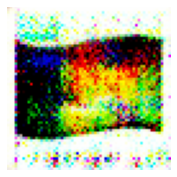

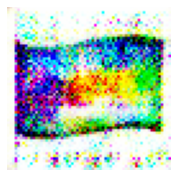

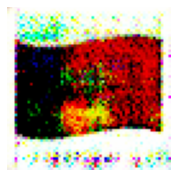

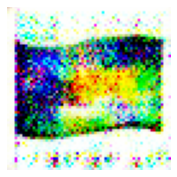

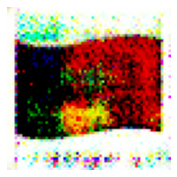

In [43]:
noise_v = sample_noise_five()

images = Generator.predict(noise_v)

view_results(noise_v,images)



In [0]:
Discriminator.save_weights(os.path.join(BASE_DIR,'discriminator_save_Fl1'),True)
Generator.save_weights(os.path.join(BASE_DIR,'Generator_save_Fl1'),True)
GAN.save_weights(os.path.join(BASE_DIR,'GAN_save_Fl1'),True)

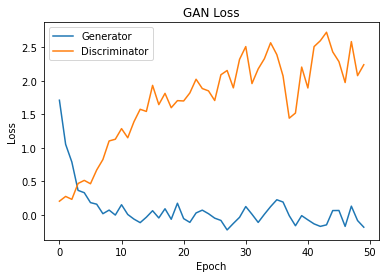

In [54]:
plot_loss(all_gen_loss,all_disc_loss)    

 This plot was from the beginning stages of my training loop. Here we can see the trend that forst the first 2-3 epochs, the generators loss is high and the initial discrminator has a good accuracy at detecting fake images from real images. However, as training proceeds, we see that the generator is improving and learning how to fool the discriminator. The discriminator hasn't been able to learn as quickly as the generator and therefore it's losses increase i.e it is easily being fooled by the generator

# Analysis of the flags dataset

Due to issues with colab, I had to take a smaller subset of the 'flags' dataset from the apple training data set.

Training on this was relatively quicker because all the flags had the same 'outline' shape so that was learnt very well by the generator. With more training, I could have achieved more realistic images of the flags. 

Even though I only trained on a small dataset of flag images, it was evident that this time around, Model Collapse wasn't as common as I was able to generate 7-9 different kinds of flags